In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 8

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-18-09-18-002956/model-7268352.meta"
# META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-052043-var-30-lev-30/model.ckpt-3062.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk.michalewski/sat-solving/models/neuropol-18-09-18-002956/model-7268352


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 20

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log_8_bench", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e6:
            return None
        
        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [14]:
class ShortCommonDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e6:
            return None
        
        sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [15]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within 1e6 steps solved {} problems out of {}".format(solved, len(sats)))
    return steps, errors

In [16]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [17]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    
    # compute_and_print_steps(sats, RandomVarDPLL)
    # compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, HybridDPLL)
    # compute_and_print_steps(sats, GraphBasedDPLL)
    # compute_and_print_steps(sats, ShortCommonDPLL)
    # compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

  6%|▌         | 6/100 [00:00<00:04, 20.71it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:03<00:00, 29.84it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 816.79; stdev step: 487.15; avg error: 6.92; stdev error: 2.07


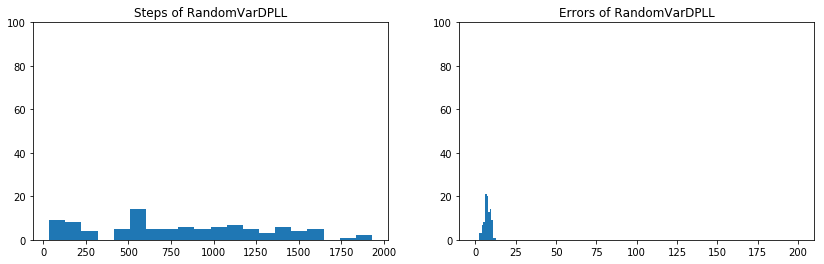

100%|██████████| 100/100 [00:02<00:00, 36.91it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 571.05; stdev step: 369.13; avg error: 4.70; stdev error: 1.63


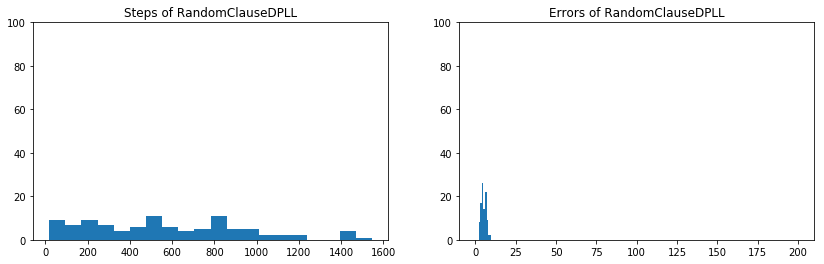

100%|██████████| 100/100 [01:38<00:00,  1.01s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 133.62; stdev step: 264.52; avg error: 0.65; stdev error: 1.41


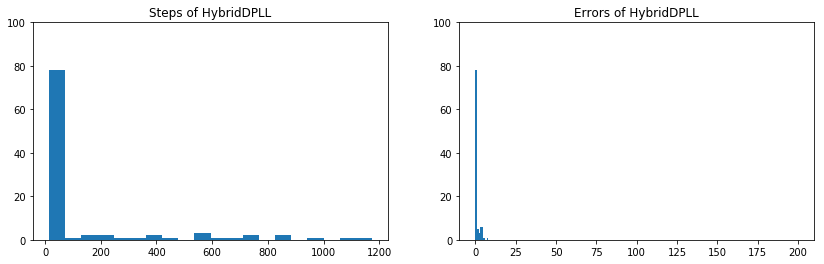

100%|██████████| 100/100 [00:01<00:00, 52.19it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 256.59; stdev step: 214.42; avg error: 2.43; stdev error: 1.27


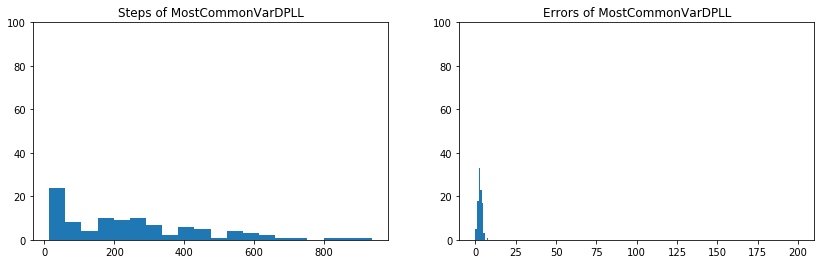

In [18]:
print_all(100, 200, 15)

 85%|████████▌ | 85/100 [00:00<00:00, 428.57it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:00<00:00, 422.88it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 67.20; stdev step: 39.19; avg error: 3.82; stdev error: 1.36


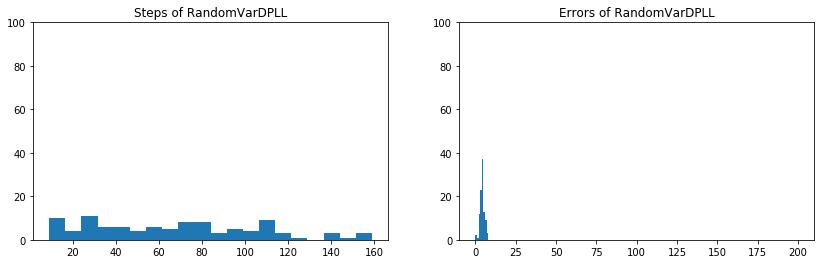

100%|██████████| 100/100 [00:00<00:00, 431.02it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 50.75; stdev step: 29.99; avg error: 2.42; stdev error: 1.10


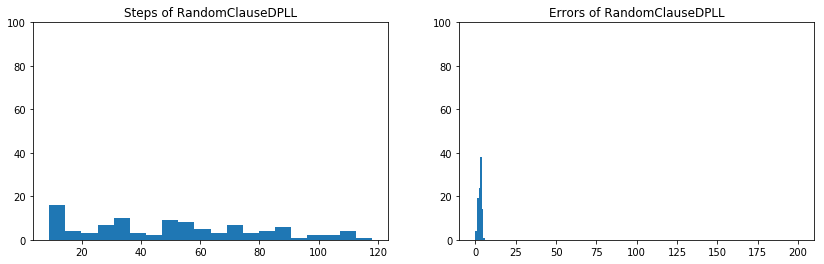

100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.20; stdev step: 10.97; avg error: 0.02; stdev error: 0.14


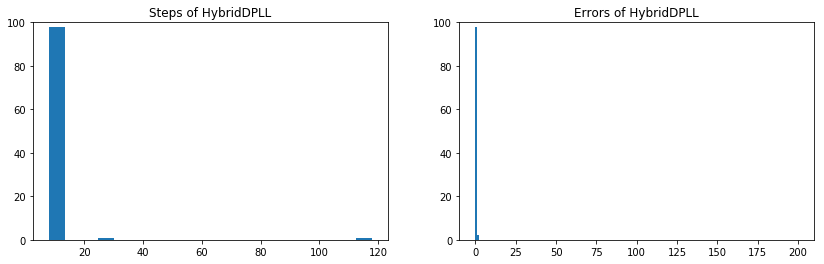

100%|██████████| 100/100 [00:00<00:00, 524.17it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 25.88; stdev step: 20.43; avg error: 0.98; stdev error: 0.85


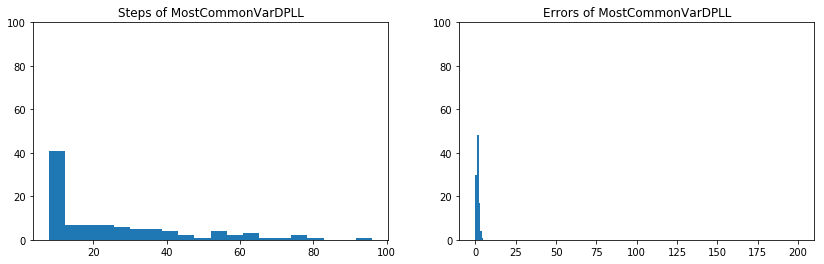

In [19]:
print_all(100, 200, 8)

 28%|██▊       | 28/100 [00:00<00:00, 98.87it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:00<00:00, 175.31it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 120.61; stdev step: 81.74; avg error: 4.94; stdev error: 1.70


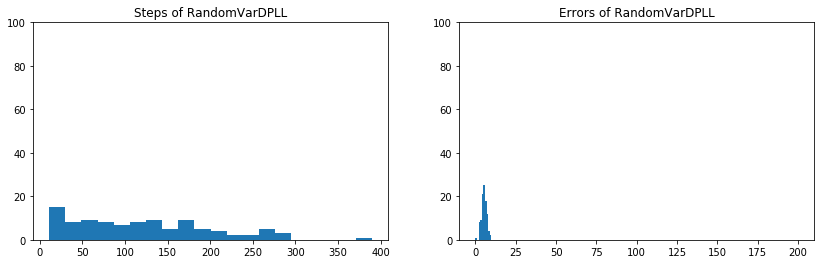

100%|██████████| 100/100 [00:00<00:00, 212.82it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 108.89; stdev step: 66.60; avg error: 3.26; stdev error: 1.35


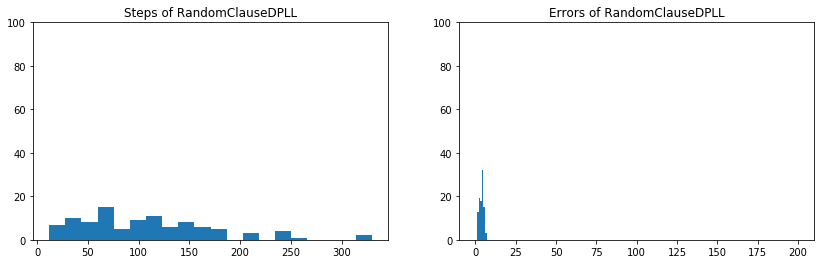

100%|██████████| 100/100 [00:34<00:00,  3.39it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.28; stdev step: 33.21; avg error: 0.06; stdev error: 0.28


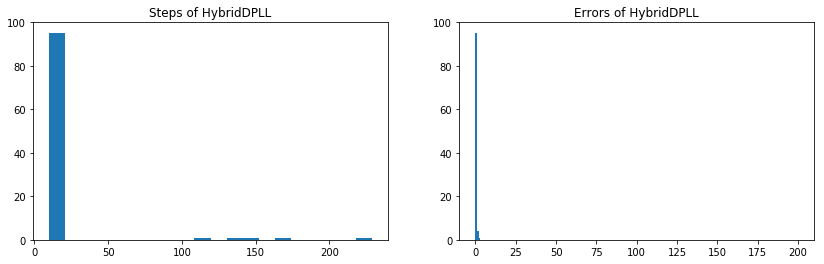

100%|██████████| 100/100 [00:00<00:00, 194.80it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 55.48; stdev step: 40.95; avg error: 1.53; stdev error: 1.01


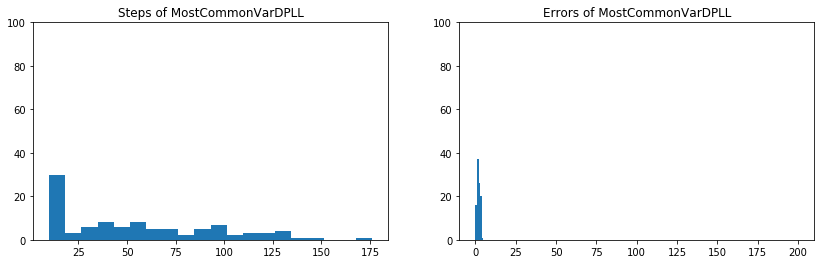

In [20]:
print_all(100, 200, 10)

 18%|█▊        | 18/100 [00:00<00:00, 88.37it/s] 

We have generated 100 formulas


100%|██████████| 100/100 [00:01<00:00, 85.80it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 272.21; stdev step: 169.20; avg error: 5.92; stdev error: 1.70


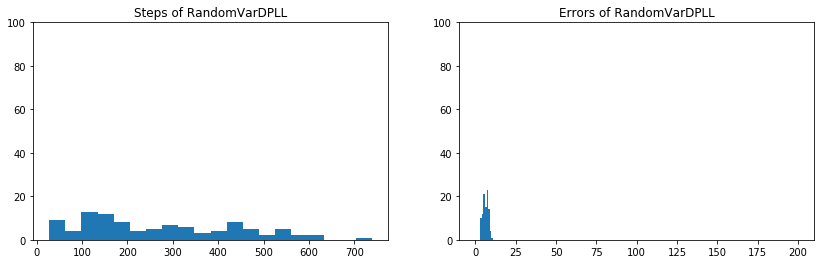

100%|██████████| 100/100 [00:00<00:00, 106.56it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 175.18; stdev step: 130.61; avg error: 3.51; stdev error: 1.53


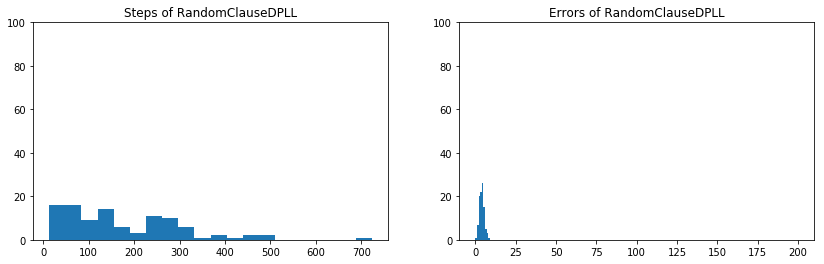

100%|██████████| 100/100 [00:57<00:00,  2.86it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 40.36; stdev step: 85.06; avg error: 0.23; stdev error: 0.72


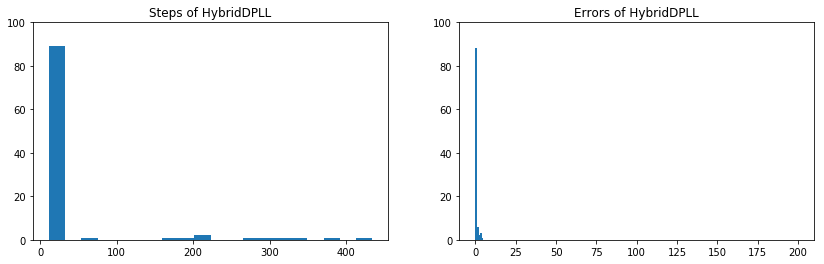

100%|██████████| 100/100 [00:00<00:00, 186.95it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 78.09; stdev step: 66.37; avg error: 1.62; stdev error: 1.06


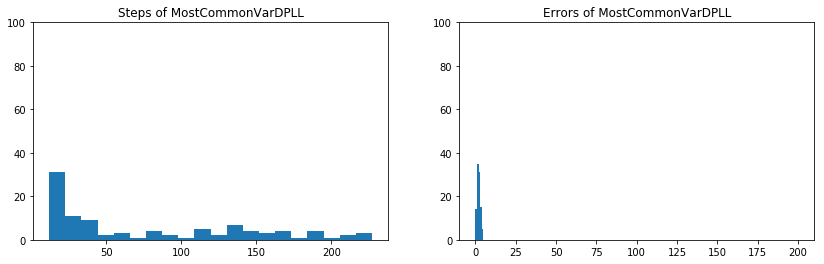

In [21]:
print_all(100, 200, 12)

 10%|█         | 10/100 [00:00<00:01, 47.75it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 537.53; stdev step: 366.86; avg error: 6.74; stdev error: 1.98


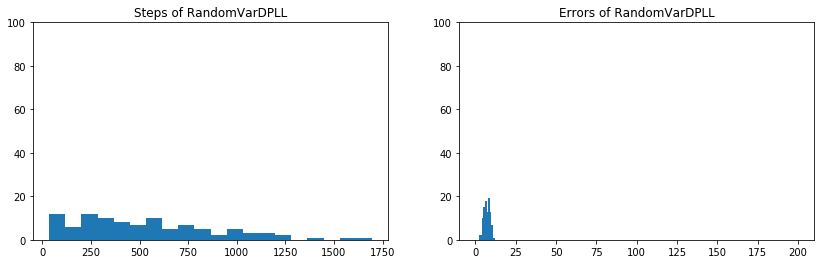

100%|██████████| 100/100 [00:02<00:00, 48.42it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 379.04; stdev step: 274.02; avg error: 4.34; stdev error: 1.65


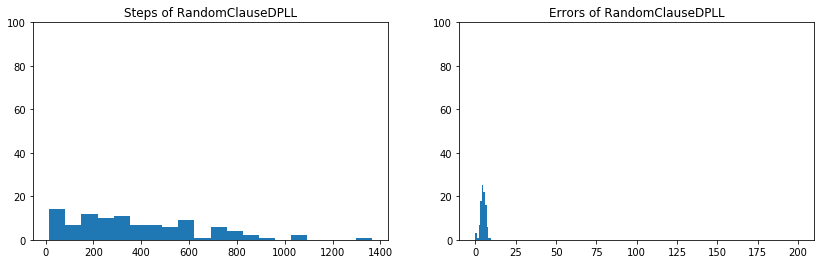

100%|██████████| 100/100 [01:23<00:00,  2.05it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 77.92; stdev step: 142.71; avg error: 0.47; stdev error: 1.12


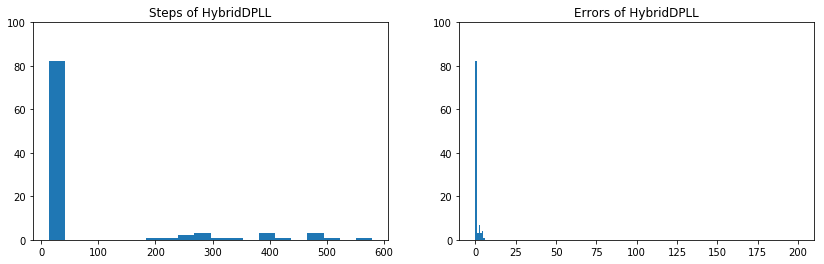

100%|██████████| 100/100 [00:01<00:00, 80.20it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 161.02; stdev step: 155.71; avg error: 2.07; stdev error: 1.37


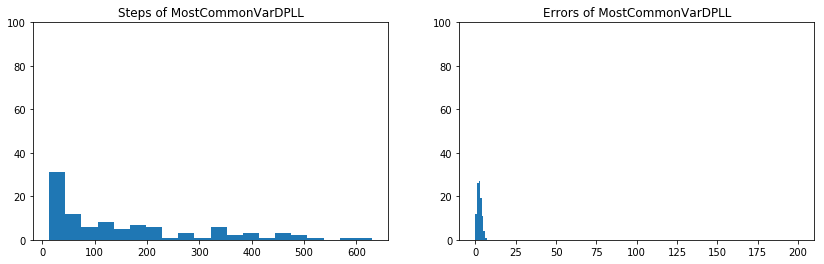

In [22]:
print_all(100, 200, 14)

  3%|▎         | 3/100 [00:00<00:11,  8.78it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 1174.53; stdev step: 763.67; avg error: 7.58; stdev error: 1.68


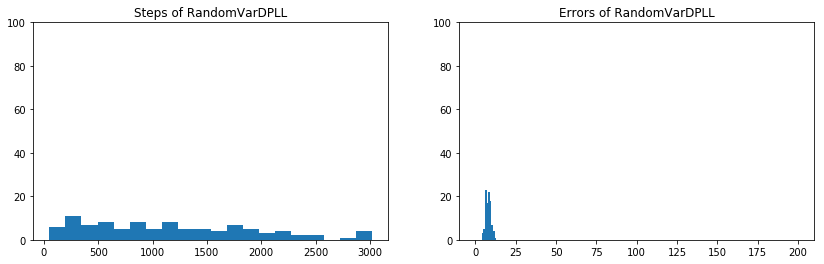

100%|██████████| 100/100 [00:04<00:00, 19.36it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 799.64; stdev step: 541.61; avg error: 5.02; stdev error: 1.82


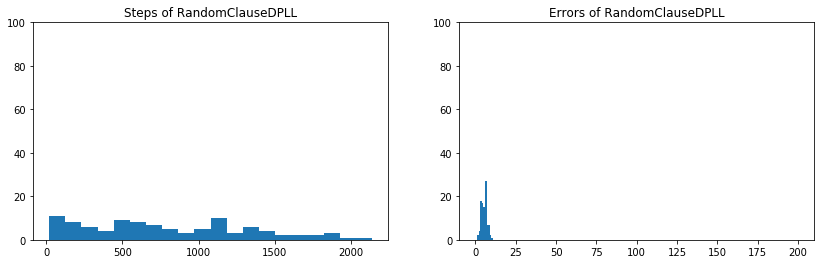

100%|██████████| 100/100 [01:43<00:00,  1.07s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 181.75; stdev step: 345.58; avg error: 0.74; stdev error: 1.48


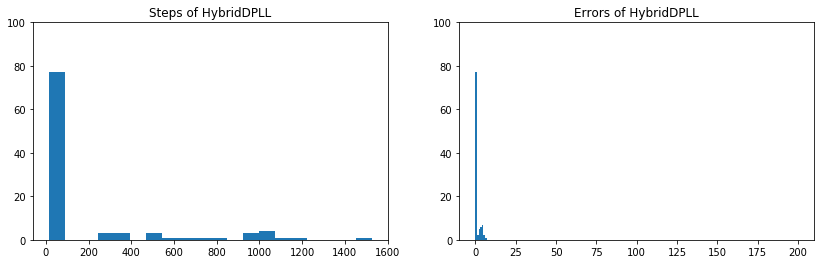

100%|██████████| 100/100 [00:02<00:00, 45.55it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 296.08; stdev step: 239.18; avg error: 2.60; stdev error: 1.10


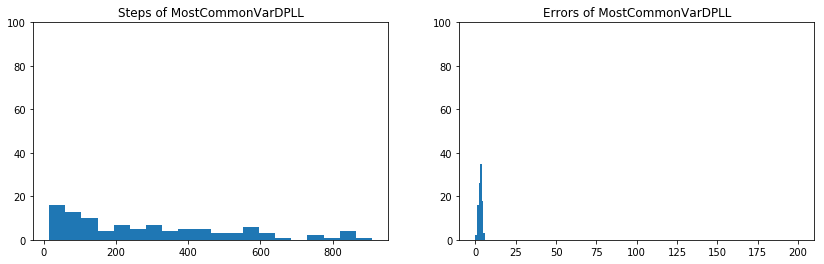

In [23]:
print_all(100, 200, 16)

  4%|▍         | 4/100 [00:00<00:11,  8.48it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:12<00:00,  6.06it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 2298.10; stdev step: 1587.01; avg error: 8.48; stdev error: 2.11


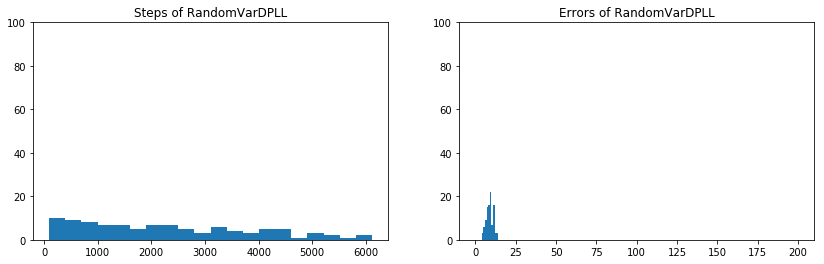

100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 1580.74; stdev step: 1033.98; avg error: 5.36; stdev error: 2.13


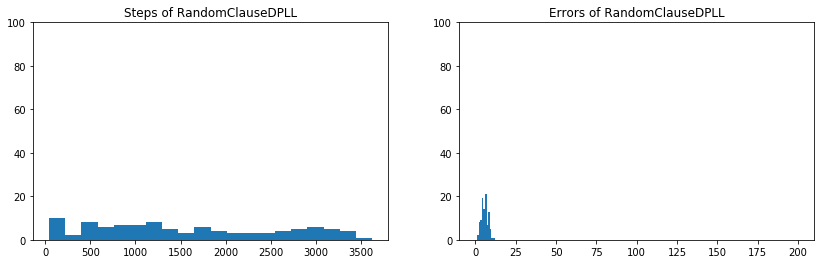

100%|██████████| 100/100 [02:16<00:00,  2.28s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 327.35; stdev step: 536.09; avg error: 1.08; stdev error: 1.68


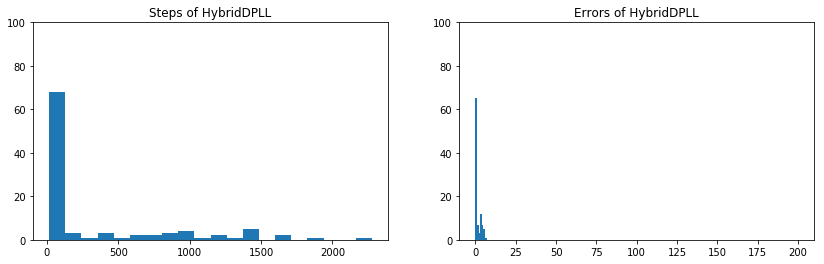

100%|██████████| 100/100 [00:04<00:00, 23.26it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 522.56; stdev step: 472.29; avg error: 2.77; stdev error: 1.26


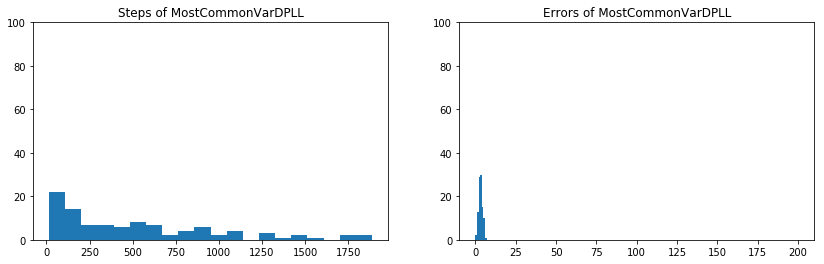

In [24]:
print_all(100, 200, 18)

  1%|          | 1/100 [00:00<00:43,  2.27it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:29<00:00,  2.93it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 5483.64; stdev step: 3345.58; avg error: 9.49; stdev error: 2.59


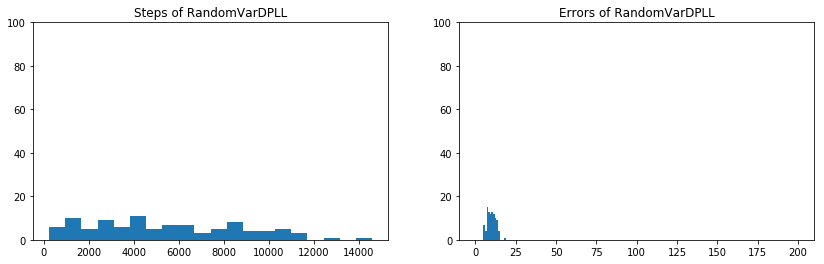

100%|██████████| 100/100 [00:14<00:00,  8.08it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 2611.59; stdev step: 2013.40; avg error: 6.23; stdev error: 1.88


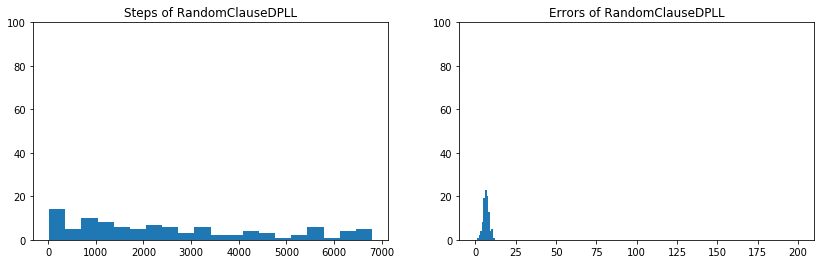

100%|██████████| 100/100 [02:28<00:00,  1.07it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 550.77; stdev step: 1022.27; avg error: 1.26; stdev error: 1.84


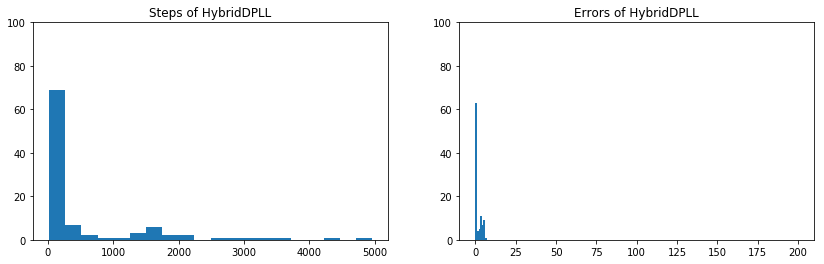

100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 961.57; stdev step: 901.44; avg error: 3.24; stdev error: 1.25


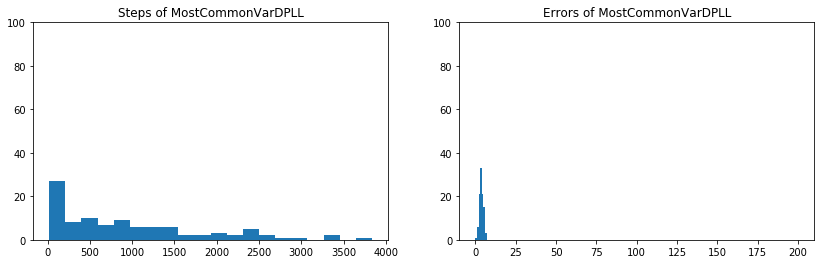

In [25]:
print_all(100, 200, 20)

  1%|          | 1/100 [00:02<04:28,  2.71s/it]

We have generated 100 formulas


100%|██████████| 100/100 [03:13<00:00,  2.29s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 27772.82; stdev step: 19956.83; avg error: 12.11; stdev error: 2.92


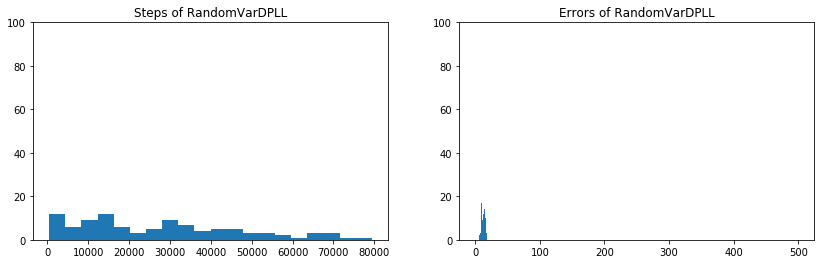

100%|██████████| 100/100 [01:38<00:00,  1.13it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 12521.50; stdev step: 8094.25; avg error: 7.75; stdev error: 2.36


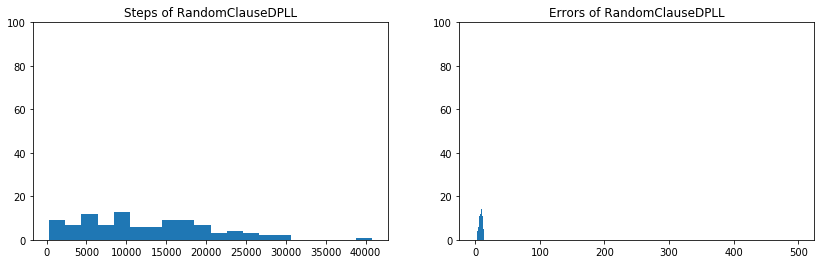

100%|██████████| 100/100 [04:47<00:00,  2.79s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 3521.66; stdev step: 4427.99; avg error: 2.60; stdev error: 2.50


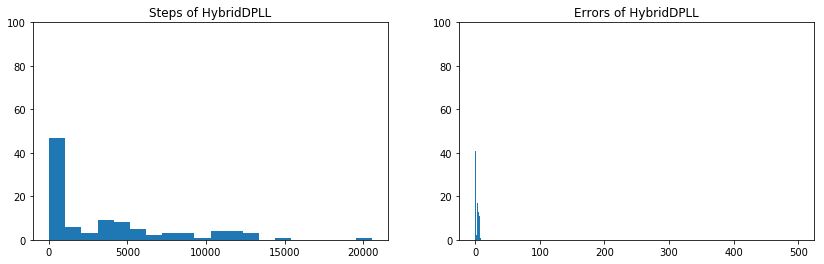

100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 4167.99; stdev step: 3942.16; avg error: 3.91; stdev error: 1.80


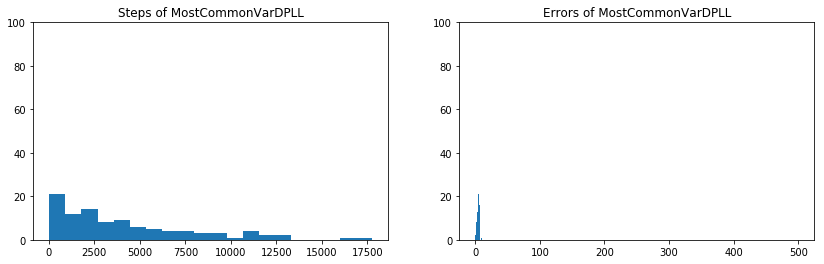

In [26]:
print_all(100, 500, 25)

  1%|          | 1/100 [00:20<33:48, 20.48s/it]

We have generated 100 formulas


100%|██████████| 100/100 [17:01<00:00, 12.03s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 121734.05; stdev step: 98621.35; avg error: 14.50; stdev error: 2.72


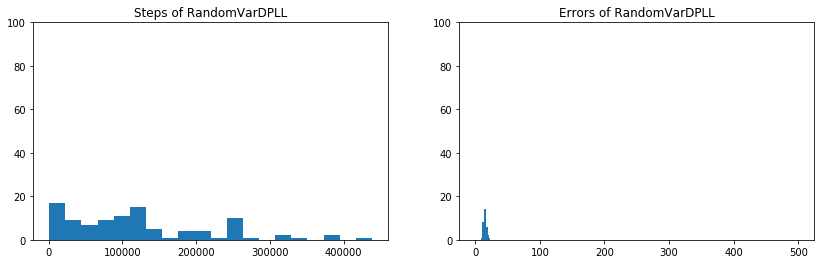

100%|██████████| 100/100 [08:05<00:00,  5.43s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 53083.67; stdev step: 39984.17; avg error: 9.10; stdev error: 2.52


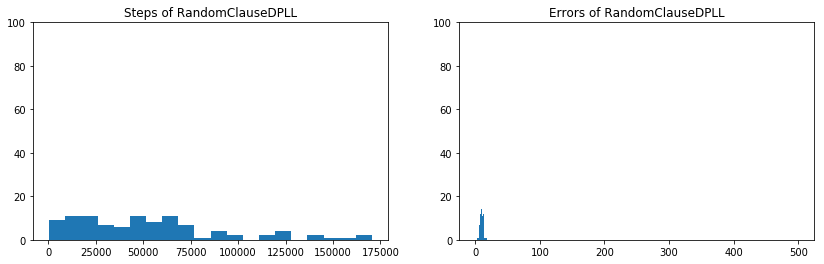

100%|██████████| 100/100 [06:54<00:00,  5.10s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 9964.74; stdev step: 14658.07; avg error: 2.95; stdev error: 2.83


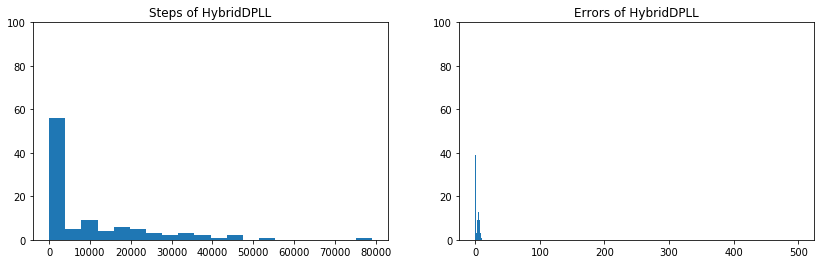

100%|██████████| 100/100 [02:38<00:00,  1.87s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 13893.86; stdev step: 13167.64; avg error: 4.86; stdev error: 1.56


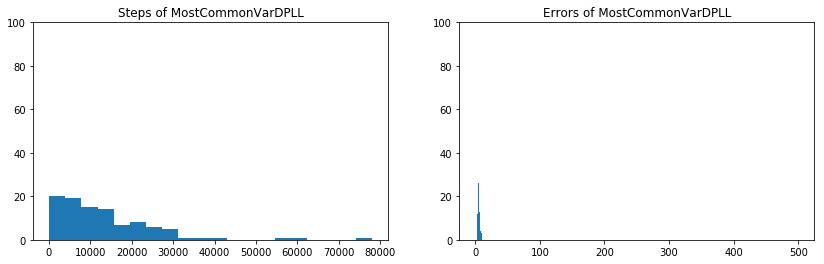

In [27]:
print_all(100, 500, 30, light=True)

 10%|█         | 1/10 [07:36<1:08:28, 456.47s/it]

We have generated 10 formulas


100%|██████████| 10/10 [52:28<00:00, 298.80s/it] 


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 2745855.40; stdev step: 1644287.16; avg error: 18.90; stdev error: 1.70


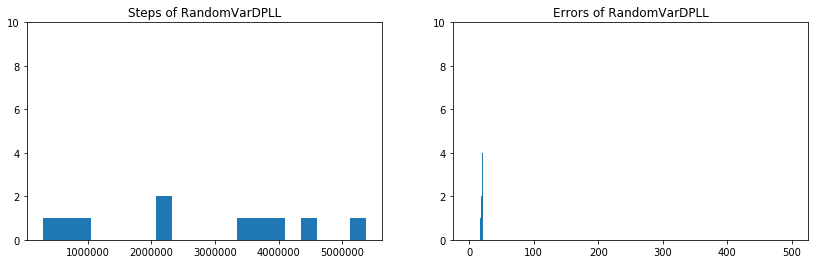

100%|██████████| 10/10 [29:43<00:00, 185.94s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 1610679.60; stdev step: 1141399.24; avg error: 12.60; stdev error: 2.33


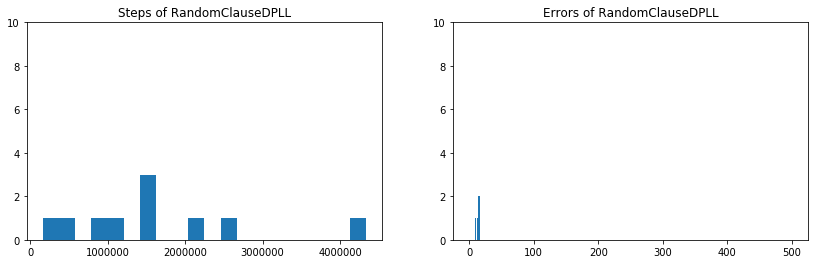

100%|██████████| 10/10 [03:45<00:00, 36.06s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 158542.60; stdev step: 295050.44; avg error: 2.50; stdev error: 2.87


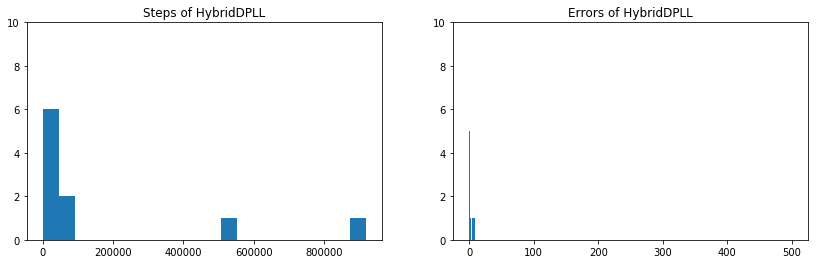

100%|██████████| 10/10 [05:36<00:00, 36.80s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 249374.70; stdev step: 306806.70; avg error: 5.80; stdev error: 2.36


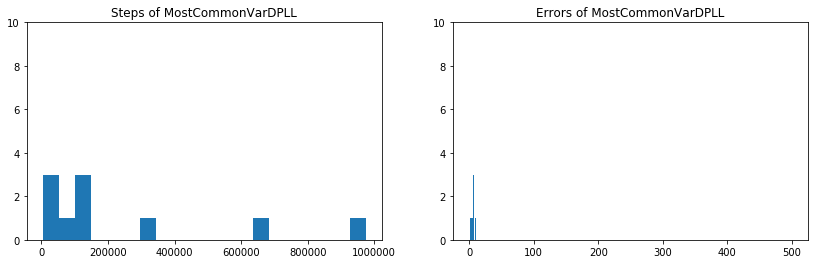

In [28]:
print_all(10, 500, 40, light=True)

In [ ]:
print_all(20, 500, 50, light=True)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

We have generated 20 formulas


100%|██████████| 20/20 [41:53<00:00, 129.73s/it]


Within 1e6 steps solved 4 problems out of 20
#Sats: 4; avg step: 70.25; stdev step: 0.43; avg error: 0.00; stdev error: 0.00


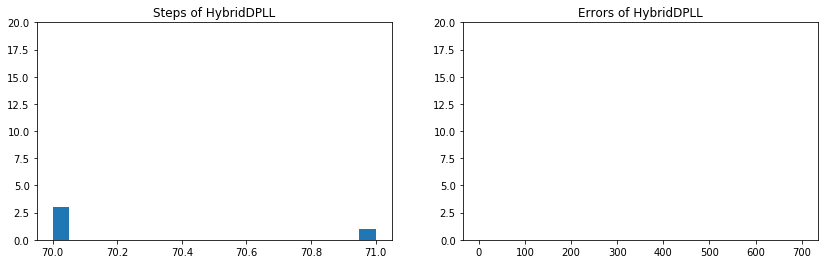

In [19]:
print_all(20, 700, 70, light=True)

In [ ]:
print_all(20, 900, 90, light=True)